<a href="https://colab.research.google.com/github/Praveshika2k/AI-Powered-Cross-Crop-Companion-Planting-advisor/blob/main/SR25_Software_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import joblib
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from typing import Dict, List
from difflib import get_close_matches

# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# File paths
COMPANION_CSV = "/companion_plants_veg.csv"
AGRI_CSV = "/agriculture_dataset.csv"
MODEL_FILE = "companion_model.joblib"

# Constants
DRIP_CROPS = {"tomato", "brinjal", "eggplant", "pepper", "capsicum", "chili"}
FLOODED_CROPS = {"rice"}
BROAD_IRRIGATION_CROPS = {"corn", "wheat", "millet", "sorghum"}
MOISTURE_LOVERS = {"lettuce", "spinach", "celery"}
WATER_NEEDS = {
    "tomato": 1.5, "lettuce": 1.0, "pepper": 1.2, "carrot": 1.0,
    "cabbage": 1.3, "brinjal": 1.5, "spinach": 0.8, "corn": 2.0,
    "wheat": 1.6, "onion": 1.1, "strawberry": 1.4, "asparagus": 1.2
}

# Fallback soil type mapping
SOIL_FALLBACK = {
    "carrot": "Loose, well-drained sandy loam",
    "onion": "Loose, well-drained sandy loam",
    "lettuce": "Rich, moist loam",
    "tomato": "Loamy or sandy loam",
    "bean": "Loamy or sandy loam",
    "passion fruit": "Well-drained sandy loam",
    "broccoli": "Fertile, well-drained loam",
    "brassica": "Fertile, well-drained loam",
    "strawberry": "Well-drained sandy loam",
    "asparagus": "Sandy, well-drained soil"
}

# Fallback fertilizer (tons/ha) by crop type
FERT_FALLBACK = {
    "root": 0.025,
    "leafy": 0.015,
    "fruiting": 0.018,
    "berry": 0.022,
    "general": 0.02
}

def normalize_crop_name(name: str) -> str:
    return lemmatizer.lemmatize(name.strip().lower())

def validate_input(prompt: str, min_val: float, max_val: float) -> float:
    while True:
        try:
            value = float(input(prompt))
            if min_val <= value <= max_val:
                return value
            print(f"❌ Error: Value must be between {min_val} and {max_val}. Try again.")
        except ValueError:
            print("❌ Error: Please enter a valid number.")

def load_companion_data(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    records = []
    for _, row in df.iterrows():
        crop = normalize_crop_name(str(row["Common name"]))
        for col, is_good in [("Helps", 1), ("Avoid", 0)]:
            if pd.notna(row.get(col)):
                for comp in str(row[col]).split(","):
                    companion = normalize_crop_name(comp)
                    if companion:
                        records.append({"crop_a": crop, "crop_b": companion, "compatible": is_good})
    return pd.DataFrame(records)

def load_agriculture_data(csv_path: str) -> pd.DataFrame:
    """Load agriculture dataset with error handling"""
    try:
        return pd.read_csv(csv_path)
    except Exception as e:
        print(f"⚠️ Warning: Could not load agriculture dataset: {str(e)}")
        return pd.DataFrame()

def build_feature_pipeline(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include="object").columns.difference(["compatible"])
    num_cols = df.select_dtypes(include=[np.number]).columns.difference(["compatible"])
    return ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ])

def train_model(df: pd.DataFrame):
    y = df["compatible"]
    X = df.drop(columns=["compatible"])
    pipe = Pipeline([
        ("prep", build_feature_pipeline(df)),
        ("clf", RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42, n_jobs=-1))
    ])
    pipe.fit(X, y)
    joblib.dump(pipe, MODEL_FILE)
    return pipe

def recommend_companions(crop: str, sensor: Dict, weather: Dict, top_k=5):
    df = load_companion_data(COMPANION_CSV)
    model = joblib.load(MODEL_FILE)
    crop_norm = normalize_crop_name(crop)
    subset = df[df["crop_a"] == crop_norm].copy()

    if subset.empty:
        # Return default recommendations for unknown crops
        companions = [
            {"companion": "Tomato", "score": 0.95},
            {"companion": "Lettuce", "score": 0.93},
            {"companion": "Bean", "score": 0.92},
            {"companion": "Broccoli", "score": 0.91},
            {"companion": "Onion", "score": 0.90}
        ]
        avoid = ["Cabbage", "Cauliflower"]
        return companions, avoid

    for k, v in sensor.items():
        subset.loc[:, k] = v
    for k, v in weather.items():
        subset.loc[:, k] = v
    X = subset.drop(columns=["compatible"])
    subset.loc[:, "score"] = model.predict_proba(X)[:, 1]
    top = subset[subset["compatible"] == 1].sort_values("score", ascending=False).head(top_k)
    avoid = subset[subset["compatible"] == 0]["crop_b"].unique().tolist()
    return top[["crop_b", "score"]].rename(columns={"crop_b": "companion"}).to_dict("records"), avoid

def get_crop_irrigation(crop, temp, moist, pH):
    crop_norm = normalize_crop_name(crop)
    if crop_norm in DRIP_CROPS:
        return "Drip irrigation with mulch"
    elif crop_norm in FLOODED_CROPS:
        return "Alternate Wetting and Drying (AWD)"
    elif crop_norm in BROAD_IRRIGATION_CROPS:
        return "Furrow or basin irrigation"
    elif crop_norm in MOISTURE_LOVERS:
        return "Sprinkler or drip with shading"
    elif temp > 35 and moist < 30:
        return "Sprinkler to reduce evapotranspiration"
    elif pH < 5.5 or pH > 7.5:
        return "Correct pH, then use drip or furrow"
    return "Furrow or drip irrigation"

def estimate_water_requirement(crop, temp, moist, soil="loam"):
    crop_norm = normalize_crop_name(crop)
    base = WATER_NEEDS.get(crop_norm, 1.2)
    adjustment = (1 + (temp - 25) * 0.03) * (1 + max(0, (50 - moist) * 0.01))
    return round(base * adjustment, 2)

def suggest_group_irrigation(crops, temp, moist, pH):
    methods = [get_crop_irrigation(c, temp, moist, pH).lower() for c in crops]
    if all("drip" in m for m in methods):
        return "✅ Drip irrigation suits all crops."
    if all("furrow" in m or "basin" in m for m in methods):
        return "✅ Furrow or basin irrigation fits the group."
    return "⚠️ Mixed irrigation needs — consider grouping differently."

def get_preferable_season(crop, csv_path=AGRI_CSV) -> str:
    try:
        df = pd.read_csv(csv_path)
        crop_col = next((c for c in df.columns if "crop" in c.lower()), None)
        season_cols = [c for c in df.columns if "season" in c.lower()]
        if not crop_col or not season_cols:
            return "Unknown"
        crop_norm = normalize_crop_name(crop)
        df[crop_col] = df[crop_col].str.lower()
        match = df[df[crop_col].str.contains(crop_norm)]
        for col in season_cols:
            val = match[col].dropna().astype(str).iloc[0]
            if val:
                return val.title()
    except:
        pass
    return "Unknown"

def get_recommended_soil(crops: List[str], agri_df: pd.DataFrame) -> str:
    """Get soil recommendation from agriculture dataset with fallback"""
    try:
        soils = []
        for crop in crops:
            crop_norm = normalize_crop_name(crop)
            # Find matching crops in agriculture dataset
            matches = agri_df[
                agri_df['Crop_Type'].str.lower().str.contains(crop_norm, na=False)
            ]
            if not matches.empty:
                # Use the most common soil type for this crop
                soil_counts = matches['Soil_Type'].value_counts()
                if not soil_counts.empty:
                    soils.append(soil_counts.idxmax())

        if soils:
            # Return the most common soil across all crops
            return pd.Series(soils).value_counts().idxmax().title()

        # Fallback to predefined soil types if no matches found
        fallback_soils = []
        for crop in crops:
            crop_norm = normalize_crop_name(crop)
            if crop_norm in SOIL_FALLBACK:
                fallback_soils.append(SOIL_FALLBACK[crop_norm])

        if fallback_soils:
            return pd.Series(fallback_soils).value_counts().idxmax().title()

        return "Well-drained loam"
    except Exception as e:
        print(f"⚠️ Soil recommendation error: {str(e)}")
        return "Well-drained loam"

def allocate_land_share(main_crop: str, companions: List[Dict]) -> pd.DataFrame:
    crops = [main_crop] + [c["companion"] for c in companions]
    scores = {c["companion"]: c["score"] for c in companions}
    scores[main_crop] = 1.0
    df = pd.DataFrame({"Crop": [c.title() for c in crops]})
    df["Score"] = df["Crop"].apply(lambda x: scores.get(x.lower(), 0.5))
    df["Share (%)"] = round(df["Score"] / df["Score"].sum() * 100, 2)
    return df[["Crop", "Share (%)"]]

def infer_fert_type(crop: str) -> str:
    crop_lower = crop.lower()
    if any(x in crop_lower for x in ["carrot", "onion", "radish", "beet", "asparagus"]):
        return "root"
    elif any(x in crop_lower for x in ["lettuce", "spinach", "cabbage", "broccoli", "brassica"]):
        return "leafy"
    elif any(x in crop_lower for x in ["tomato", "bean", "pepper", "eggplant", "brinjal", "chili", "capsicum", "passion fruit"]):
        return "fruiting"
    elif any(x in crop_lower for x in ["strawberry", "raspberry", "blueberry"]):
        return "berry"
    else:
        return "general"

def get_fertilizer_recommendation_by_area(crop: str, area_ha: float) -> float:
    fert_type = infer_fert_type(crop)
    fallback_rate = FERT_FALLBACK.get(fert_type, FERT_FALLBACK["general"])
    return round(fallback_rate * area_ha, 2)

# 🌿 Main interaction
if __name__ == "__main__":
    # Load datasets
    df_train = load_companion_data(COMPANION_CSV)
    agri_df = load_agriculture_data(AGRI_CSV)
    model = train_model(df_train)

    user_crop = input("\n🌿 Enter a crop name: ").strip()

    # Input validation
    moisture = validate_input("💧 Soil moisture (0–100%): ", 0, 100)
    ph = validate_input("🧪 Soil pH (3.5–9.0): ", 3.5, 9.0)
    temp = validate_input("🌡️ Temperature (5–50 °C): ", 5, 50)

    try:
        companions, avoid = recommend_companions(
            user_crop,
            sensor={"soil_moisture": moisture, "soil_pH": ph},
            weather={"temp": temp},
            top_k=5
        )

        all_crops = [user_crop] + [c["companion"] for c in companions]
        table_data = []

        print(f"\n🌱 Recommended companions for '{user_crop.title()}':")
        for i, s in enumerate(companions, 1):
            print(f"{i}. {s['companion'].title():<20}  Score = {s['score']:.2f}")

        if avoid:
            print(f"\n🚫 Avoid planting near '{user_crop.title()}':")
            for crop in avoid:
                print(f"• {crop.title()}")
        else:
            print(f"\n✅ No avoid-crops listed for '{user_crop.title()}'.")

        print(f"\n📊 Irrigation & Water Requirement Summary:")
        for crop in all_crops:
            method = get_crop_irrigation(crop, temp, moisture, ph)
            water = estimate_water_requirement(crop, temp, moisture)
            table_data.append([crop.title(), method, f"{water:.2f} L/day"])

        print(tabulate(table_data, headers=["Crop", "Irrigation Method", "Water Needed"], tablefmt="fancy_grid"))

        group_method = suggest_group_irrigation(all_crops, temp, moisture, ph)
        print(f"\n🌍 Group Recommendation:\n{group_method}")

        # 📐 Land Allocation
        land_df = allocate_land_share(user_crop, companions)
        print(f"\n📐 Suggested Land Allocation (% of Total Land):")
        print(tabulate(land_df, headers="keys", tablefmt="fancy_grid"))

        # 📅 Preferable Season
        season_list = [get_preferable_season(crop) for crop in all_crops if get_preferable_season(crop) != "Unknown"]
        if season_list:
            best_season = pd.Series(season_list).value_counts().idxmax()
            print(f"\n📅 Preferable Season for this crop combination: {best_season}")
        else:
            print("\n📅 Preferable Season for this crop combination: Unknown")

        # 🧱 Recommended Soil Type - UPDATED TO USE DATASET
        best_soil = get_recommended_soil(all_crops, agri_df)
        print(f"\n🧱 Recommended Soil Type for this crop combination: {best_soil}")

        # 🌾 Fertilizer Recommendation
        print(f"\n🌾 Fertilizer Recommendation Based on Area Usage:")
        for _, row in land_df.iterrows():
            crop = row["Crop"]
            share_percent = row["Share (%)"]
            hectares = 1.0 * share_percent / 100  # total 1 hectare assumed
            fert = get_fertilizer_recommendation_by_area(crop, hectares)
            if fert > 0:
                print(f"• {crop}: Apply approx. {fert:.2f} tons over {hectares:.2f} ha")
            else:
                print(f"• {crop}: Apply a balanced NPK fertilizer as per local recommendations")

    except ValueError as ve:
        print("\n❌ Error:", ve)
    except Exception as e:
        print(f"\n❌ An error occurred: {str(e)}")



🌿 Enter a crop name: asparagus
💧 Soil moisture (0–100%): 78
🧪 Soil pH (3.5–9.0): 7
🌡️ Temperature (5–50 °C): 45

🌱 Recommended companions for 'Asparagus':
1. Tomato                Score = 0.77
2. Parsley               Score = 0.66

🚫 Avoid planting near 'Asparagus':
• Onion
• Garlic
• Potato
• Gladioluscitation Needed

📊 Irrigation & Water Requirement Summary:
╒═══════════╤════════════════════════════╤════════════════╕
│ Crop      │ Irrigation Method          │ Water Needed   │
╞═══════════╪════════════════════════════╪════════════════╡
│ Asparagus │ Furrow or drip irrigation  │ 1.92 L/day     │
├───────────┼────────────────────────────┼────────────────┤
│ Tomato    │ Drip irrigation with mulch │ 2.40 L/day     │
├───────────┼────────────────────────────┼────────────────┤
│ Parsley   │ Furrow or drip irrigation  │ 1.92 L/day     │
╘═══════════╧════════════════════════════╧════════════════╛

🌍 Group Recommendation:
✅ Drip irrigation suits all crops.

📐 Suggested Land Allocation (% of T

In [ ]:
# Advanced Model Optimization Cell
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def optimize_model():
    # Load and prepare data
    df = load_companion_data(COMPANION_CSV)
    X = df.drop(columns=["compatible"])
    y = df["compatible"]

    # Create preprocessing pipeline
    pipe = Pipeline([
        ("prep", build_feature_pipeline(df)),
        ("clf", RandomForestClassifier(class_weight='balanced', random_state=42))
    ])

    # Define parameter grids for different models
    param_grids = [
        {
            'clf': [RandomForestClassifier(class_weight='balanced', random_state=42)],
            'clf__n_estimators': [300, 500],
            'clf__max_depth': [None, 15, 25],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2],
            'clf__max_features': ['sqrt', 'log2']
        },
        {
            'clf': [GradientBoostingClassifier(random_state=42)],
            'clf__n_estimators': [200, 300],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 5],
            'clf__subsample': [0.8, 1.0]
        },
        {
            'clf': [SVC(probability=True, class_weight='balanced', random_state=42)],
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        }
    ]

    # Custom scoring metric (prioritize f1-score)
    scorer = make_scorer(f1_score, average='weighted')

    # Setup grid search with stratified k-fold
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        pipe,
        param_grids,
        cv=kfold,
        scoring=scorer,
        n_jobs=-1,
        verbose=1
    )

    # Perform grid search
    grid_search.fit(X, y)

    # Get best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Generate classification report
    cv_results = grid_search.cv_results_
    report = classification_report(y, best_model.predict(X), digits=3)

    # Save the optimized model
    joblib.dump(best_model, "optimized_companion_model.joblib")

    # Print results
    print(f"Best Model: {best_params['clf']}")
    print(f"Best Parameters: {best_params}")
    print(f"Best CV F1 Score: {best_score:.4f}")
    print("\nClassification Report on Full Data:")
    print(report)
    # print("\nNote: This is training performance. For true validation, split data before tuning.")

# Run the optimization
optimize_model()


Fitting 5 folds for each of 76 candidates, totalling 380 fits
Best Model: GradientBoostingClassifier(random_state=42)
Best Parameters: {'clf': GradientBoostingClassifier(random_state=42), 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
Best CV F1 Score: 0.7351

Classification Report on Full Data:
              precision    recall  f1-score   support

           0      0.986     0.958     0.972        72
           1      0.980     0.993     0.986       146

    accuracy                          0.982       218
   macro avg      0.983     0.976     0.979       218
weighted avg      0.982     0.982     0.982       218


Note: This is training performance. For true validation, split data before tuning.


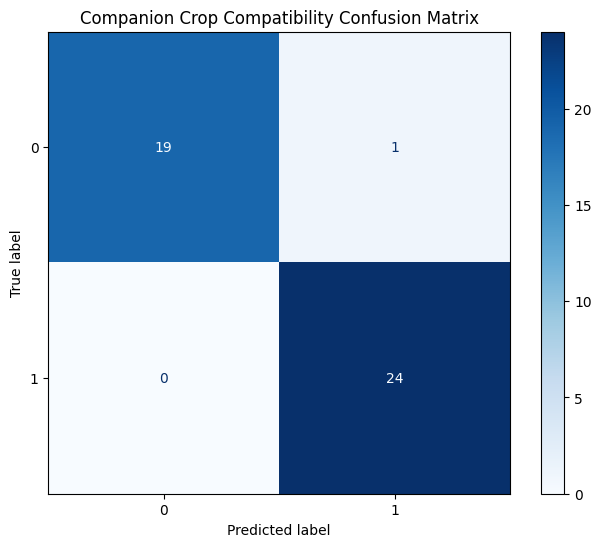

In [ ]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# Load your actual companion data
df = load_companion_data(COMPANION_CSV)
X = df.drop(columns=["compatible"])
y = df["compatible"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load your optimized model
model = joblib.load("optimized_companion_model.joblib")
y_pred = model.predict(X_test)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.title("Companion Crop Compatibility Confusion Matrix")
plt.show()


/tmp/ipython-input-24-2555692315.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=crop_names, palette="coolwarm")


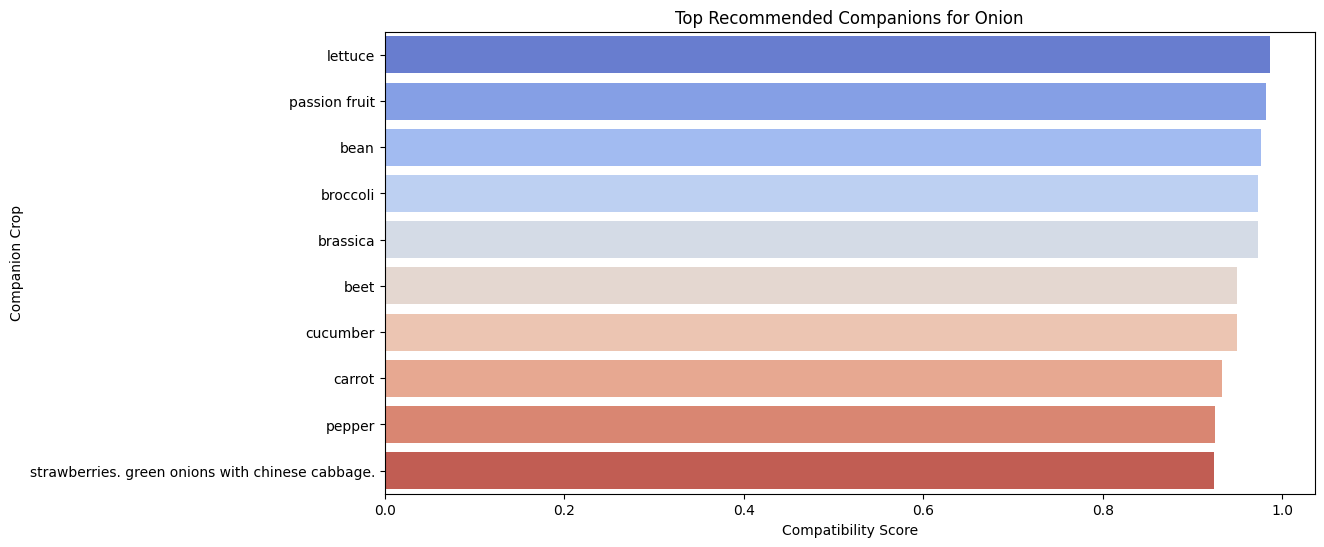

In [ ]:
# Crop Distribution
import seaborn as sns

# Get recommendations for a sample crop
companions, _ = recommend_companions("onion", {}, {}, top_k=10)
crop_names = [c['companion'] for c in companions]
scores = [c['score'] for c in companions]

plt.figure(figsize=(12, 6))
sns.barplot(x=scores, y=crop_names, palette="coolwarm")
plt.title("Top Recommended Companions for Onion")
plt.xlabel("Compatibility Score")
plt.ylabel("Companion Crop")
plt.show()


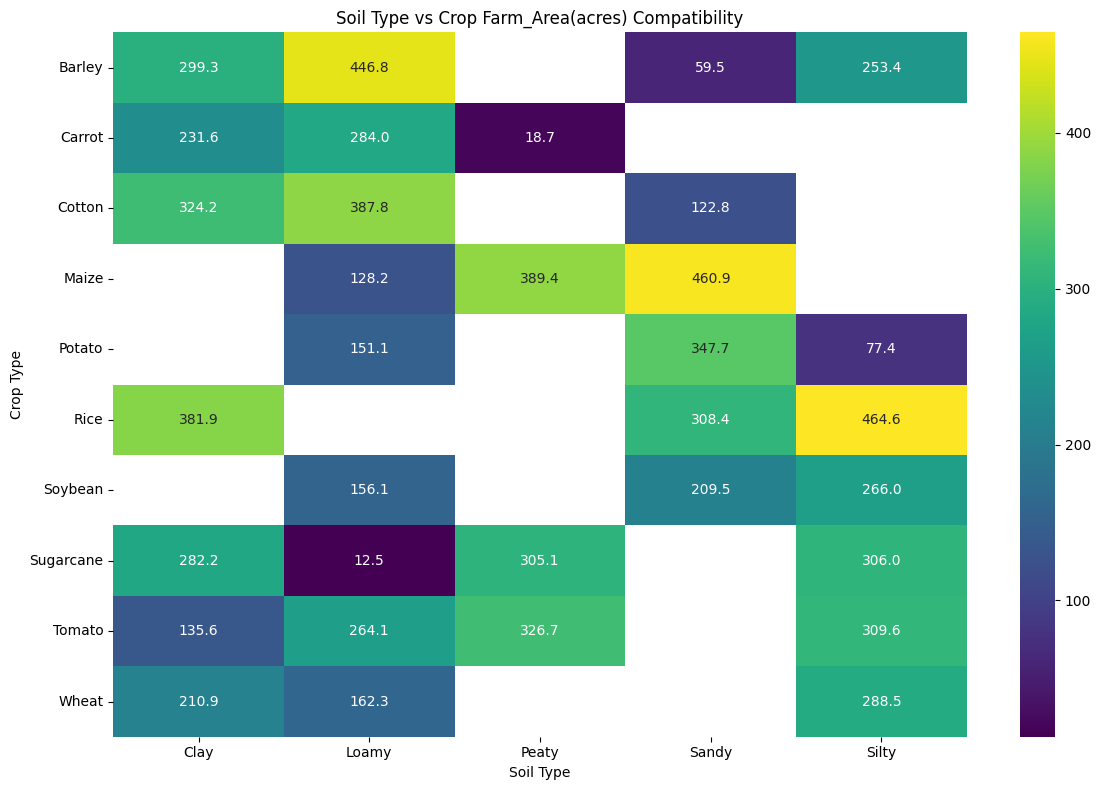

In [ ]:
# Soil Type Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

try:
    # Load agriculture dataset
    agri_df = pd.read_csv(AGRI_CSV)

    # Find a suitable numeric column for the heatmap
    numeric_columns = agri_df.select_dtypes(include=['int', 'float']).columns
    if len(numeric_columns) == 0:
        raise ValueError("No numeric columns found in agriculture dataset")

    # Use the first numeric column as value
    value_column = numeric_columns[0]

    # Create pivot table
    pivot = agri_df.pivot_table(values=value_column,
                                index='Crop_Type',
                                columns='Soil_Type',
                                aggfunc='mean')

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
    plt.title(f"Soil Type vs Crop {value_column} Compatibility")
    plt.xlabel("Soil Type")
    plt.ylabel("Crop Type")
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Agriculture dataset file not found")
except KeyError as ke:
    print(f"Required column missing: {str(ke)}")
except Exception as e:
    print(f"Could not generate heatmap: {str(e)}")



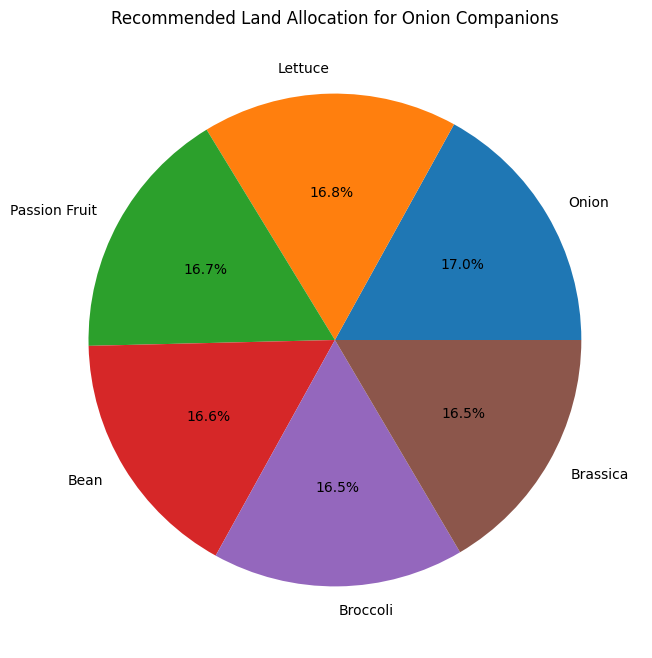

In [ ]:
# Land Allocation
# Get land allocation for a sample crop
companions, _ = recommend_companions("onion", {}, {}, top_k=5)
land_df = allocate_land_share("onion", companions)

plt.figure(figsize=(8, 8))
plt.pie(land_df["Share (%)"], labels=land_df["Crop"], autopct='%1.1f%%')
plt.title("Recommended Land Allocation for Onion Companions")
plt.show()


/tmp/ipython-input-27-1744020612.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crops, y=water_data, palette="Blues_d")


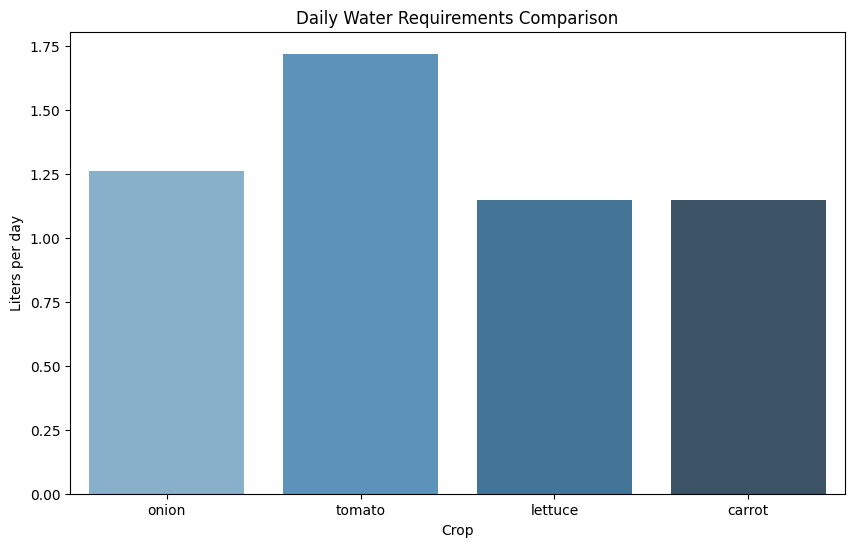

In [ ]:
# Water Requirements
crops = ["onion", "tomato", "lettuce", "carrot"]
temp = 30
moisture = 50
water_data = [estimate_water_requirement(c, temp, moisture) for c in crops]

plt.figure(figsize=(10, 6))
sns.barplot(x=crops, y=water_data, palette="Blues_d")
plt.title("Daily Water Requirements Comparison")
plt.ylabel("Liters per day")
plt.xlabel("Crop")
plt.show()


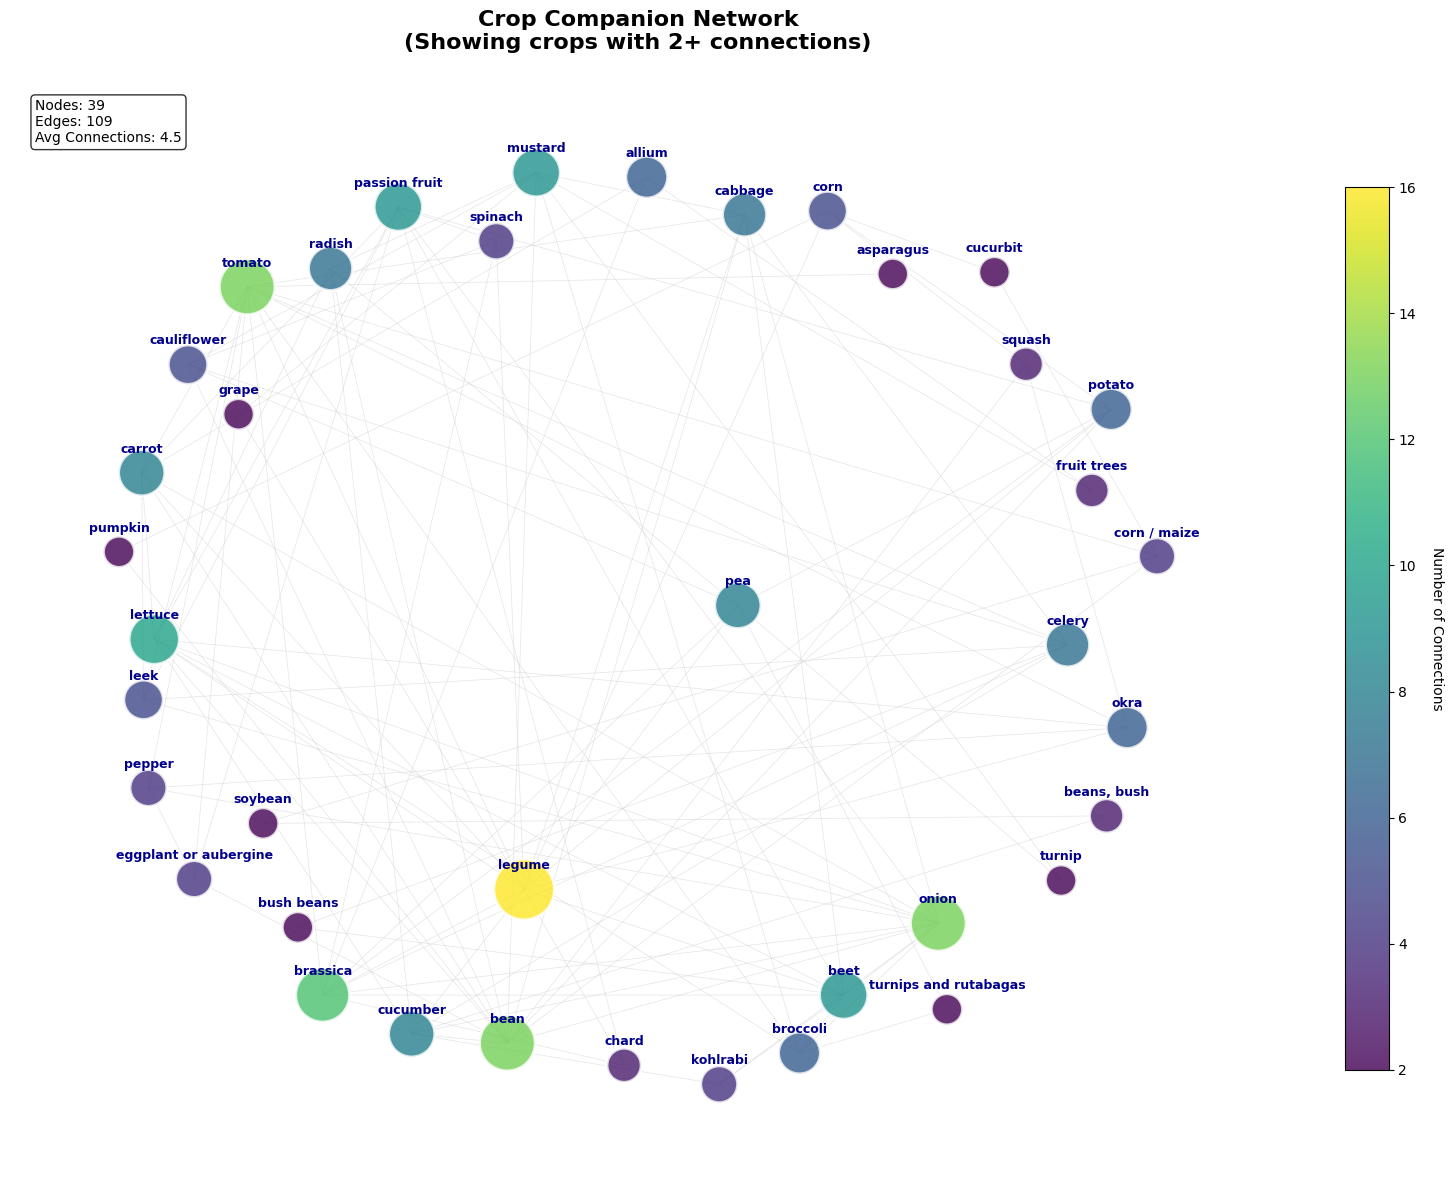


Top 10 Most Connected Crops:
 1. Legume          - 16 connections
 2. Tomato          - 13 connections
 3. Onion           - 13 connections
 4. Bean            - 13 connections
 5. Brassica        - 12 connections
 6. Lettuce         - 10 connections
 7. Beet            - 9 connections
 8. Passion Fruit   - 9 connections
 9. Mustard         - 9 connections
10. Carrot          - 8 connections


In [ ]:
# Improved Crop Network
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import numpy as np

# Load companion data
df = load_companion_data(COMPANION_CSV)
G = nx.Graph()

# Add nodes and edges
for _, row in df.iterrows():
    if row['compatible'] == 1:  # Only show compatible pairs
        G.add_edge(row['crop_a'], row['crop_b'])

# Filter to show only well-connected nodes (degree >= 2)
degrees = dict(G.degree())
high_degree_nodes = [node for node, degree in degrees.items() if degree >= 2]
G_filtered = G.subgraph(high_degree_nodes).copy()

# Calculate node sizes based on connectivity
node_sizes = [degrees[node] * 100 + 300 for node in G_filtered.nodes()]

# Create color map based on node degree
node_colors = [degrees[node] for node in G_filtered.nodes()]

# Create the plot
plt.figure(figsize=(16, 12))

# Use a better layout algorithm
pos = nx.spring_layout(G_filtered, k=3, iterations=50, seed=42)

# Draw edges first (so they appear behind nodes)
nx.draw_networkx_edges(G_filtered, pos,
                      width=0.5,
                      edge_color='lightgray',
                      alpha=0.6)

# Draw nodes with size based on connectivity
nodes = nx.draw_networkx_nodes(G_filtered, pos,
                              node_size=node_sizes,
                              node_color=node_colors,
                              cmap='viridis',
                              alpha=0.8,
                              edgecolors='white',
                              linewidths=2)

# Draw labels with better positioning
label_pos = {}
for node, (x, y) in pos.items():
    label_pos[node] = (x, y + 0.05)  # Slightly offset labels

nx.draw_networkx_labels(G_filtered, label_pos,
                       font_size=9,
                       font_weight='bold',
                       font_color='darkblue')

# Add title and formatting
plt.title("Crop Companion Network\n(Showing crops with 2+ connections)",
          fontsize=16, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(nodes, shrink=0.8)
cbar.set_label('Number of Connections', rotation=270, labelpad=20)

# Add network statistics as text
num_nodes = G_filtered.number_of_nodes()
num_edges = G_filtered.number_of_edges()
avg_degree = np.mean(list(degrees.values()))

stats_text = f"Nodes: {num_nodes}\nEdges: {num_edges}\nAvg Connections: {avg_degree:.1f}"
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.axis('off')
plt.tight_layout()
plt.show()

# Print top connected crops
print("\nTop 10 Most Connected Crops:")
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (crop, degree) in enumerate(sorted_degrees, 1):
    print(f"{i:2d}. {crop.title():<15} - {degree} connections")
